In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats as st
from scipy.special import expit as sigmoid
from scipy import stats

from scipy import sparse
from scipy.stats import multivariate_normal

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from copy import copy
from IPython.display import Image
import pickle
from datetime import datetime, timedelta
import json
import gc
import re
from tqdm import tqdm
from collections import defaultdict, Counter


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [2]:
!wget https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 
!unzip chgk.zip  -d chgk

--2022-04-21 16:08:30--  https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s4qj0fpsn378m2i/chgk.zip [following]
--2022-04-21 16:08:30--  https://www.dropbox.com/s/raw/s4qj0fpsn378m2i/chgk.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc23e24b4fc10a0e479ec45644ad.dl.dropboxusercontent.com/cd/0/inline/Bj1Fp0_7CyNnIxZWrXCs6oiTTRmqKZkn3ayF39kA3UYd30cwIg8ookfrEBn6op_UlNYXoUu-qMqSiCNRMc3lic4poKNrHIxGO9T3WTzi0RBz3mHlBZpw8mduIYOHY-dO1_bYTyMMnC5fSz44OHnuJezplALRVB3V3nx0MSLC8Ijrxw/file# [following]
--2022-04-21 16:08:31--  https://uc23e24b4fc10a0e479ec45644ad.dl.dropboxusercontent.com/cd/0/inline/Bj1Fp0_7CyNnIxZWrXCs6oiTTRmqKZkn3ayF39kA3UYd30cwIg8ookfrEBn6op_UlNYXoUu-qMqSi

# 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах

In [2]:
results = pickle.load(open("chgk/results.pkl", "rb"))

In [25]:
players_df = pd.DataFrame(pickle.load(open("chgk/players.pkl", "rb"))).transpose()

In [26]:
tournaments_df = pd.DataFrame(pickle.load(open("chgk/tournaments.pkl", "rb"))).transpose()
tournaments_df.dateStart = pd.to_datetime(tournaments_df.dateStart)

In [27]:
tournaments_df.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25 00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09 00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22 00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11 00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10 00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [28]:
players_df.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [8]:
train_start_date = pd.to_datetime("2019/01/01 00:00:00", utc=True)
train_end_date = pd.to_datetime("2019/12/31 23:59:59", utc=True)
train_tournaments_index = tournaments_df[tournaments_df.dateStart.between(train_start_date, train_end_date)].id
train = []
tour_question_dict = {}

for tour_id in train_tournaments_index:
    tournament = results.get(tour_id, -1)
    if tournament == -1:
        continue
    for team in tournament:
        mask = team.get("mask", "")
        if not mask or re.sub("[0-1]+", "", mask):
            continue
                  
        team_id = int(team["team"]["id"])
        
        for member in team["teamMembers"]:
            player_id = member['player']['id']
            for quest_idx, answ in enumerate([int(i) for i in mask]):
                train.append([tour_id, team_id, player_id, str(tour_id) + "_" + str(quest_idx), int(answ)])
    

df_train = pd.DataFrame(train)
df_train.columns = ['tournament_id', 'team_id', 'player_id', 'question_id', 'answer']


In [9]:
df_train.to_csv("train.csv", index=False)

In [10]:
df_train.head()

,tournament_id,team_id,player_id,question_id,answer
0,4772,45556,6212,4772_0,1
1,4772,45556,6212,4772_1,1
2,4772,45556,6212,4772_2,1
3,4772,45556,6212,4772_3,1
4,4772,45556,6212,4772_4,1


In [11]:
test_start_date = pd.to_datetime("2020/01/01 00:00:00", utc=True)
test_end_date = pd.to_datetime("2020/12/31 23:59:59", utc=True)
test_tournaments_index = tournaments_df[tournaments_df.dateStart.between(test_start_date, test_end_date)].id
test = []
#test_position = []
for tour_id in test_tournaments_index:
    tournament = results.get(tour_id, -1)
    if tournament == -1:
        continue
    
    for team in tournament:
        mask = team.get("mask", "")
        if not mask or re.sub("[0-1]+", "", mask):
            continue
        team_id = int(team["team"]["id"])
        for member in team["teamMembers"]:
            player_id = member['player']['id']
            for quest_idx, answ in enumerate([int(i) for i in mask]):
                test.append([tour_id, team_id, player_id, str(tour_id) + "_" + str(quest_idx), int(answ)])
    

    

In [13]:
df_test = pd.DataFrame(test)
df_test.columns = ['tournament_id', 'team_id', 'player_id', 'question_id', 'answer']

In [14]:
df_test.to_csv("test.csv", index=False)

In [15]:
df_test.head()

,tournament_id,team_id,player_id,question_id,answer
0,5414,66120,18490,5414_0,1
1,5414,66120,18490,5414_1,1
2,5414,66120,18490,5414_2,1
3,5414,66120,18490,5414_3,1
4,5414,66120,18490,5414_4,1


# Baseline model

In [3]:
one_hot = ColumnTransformer(
    transformers=[
            ('OneHot', OneHotEncoder(), ['tournament_id', 'player_id'])
    ],
        remainder='drop',
        sparse_threshold=1
    )
pipe = Pipeline(
        verbose=True,
        steps=[
            ('one_hot', one_hot),
            ('logreg', LogisticRegression(solver='liblinear', max_iter=100))
        ]
    )
pipe.fit(df_train[['tournament_id', 'player_id']], df_train['answer'])

In [ ]:
player_features_start_pos = df_train.nunique()['tournament_id']
player_features_names = pipe['one_hot'].get_feature_names()[player_features_start_pos:]
player_ids = [int(name[11:]) for name in player_features_names]
    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
player_weights = pipe['logreg'].coef_[0][player_features_start_pos:]

In [ ]:
map_id_to_weight = dict(zip(player_ids, player_weights))

In [ ]:
map_id_to_weight = dict(sorted(map_id_to_weight.items(), key=lambda item: item[1], reverse=True))

In [ ]:
i = 0
top_100 = []
for player_id, score in map_id_to_weight.items():
    if i >= 100:
        break
    player = players_df[players_df.id == player_id]
    player_name = player.name.values[0] + " " + player.patronymic.values[0] + " " + player.surname.values[0]
    top_100.append([player_name, score])
    i += 1

In [ ]:
df_top_100 = pd.DataFrame(top_100)
df_top_100.columns = ['player', 'score']

In [ ]:
print(df_top_100.to_string())

                                player     score
0              Максим Михайлович Руссо  3.054470
1       Александра Владимировна Брутер  2.958484
2              Иван Николаевич Семушин  2.930479
3         Павел Константинович Щербина  2.920203
4        Михаил Владимирович Савченков  2.838343
5             Артём Сергеевич Сорожкин  2.816262
6            Сергей Леонидович Спешков  2.813738
7            Михаил Ильич Левандовский  2.737340
8            Сергей Игоревич Николенко  2.719096
9          Антон Владимирович Саксонов  2.718981
10          Ирина Сергеевна Прокофьева  2.700075
11   Станислав Григорьевич Мереминский  2.689753
12          Александр Витальевич Либер  2.667300
13         Наталья Евгеньевна Горелова  2.658258
14      Александр Владимирович Мосягин  2.654457
15              Илья Сергеевич Новиков  2.641404
16             Сусанна Марковна Бровер  2.629812
17              Игорь Викторович Мокин  2.627556
18          Алексей Владимирович Гилёв  2.625659
19              Мари

# 3 Качество рейтинг системы

In [ ]:
def get_prediction(tournament, player_to_weight, orginal_position_dict):
    predict_weight_dict = defaultdict(lambda : 0)
    avg_weight = np.mean([v for v in player_to_weight.values()])
    for idx, team in enumerate(tournament):
        weight = 0
        for player_info in team['teamMembers']:
            p_id = player_info['player']['id']
            try:
                weight += player_to_weight[p_id]
            except:
                weight += avg_weight
        predict_weight_dict[team["team"]["id"]] = weight
    predict_weight_dict = dict(sorted(predict_weight_dict.items(), key=lambda item: item[1], reverse=True))
    predict_position_dict = dict(zip(predict_weight_dict.keys(), range(1, len(predict_weight_dict) + 1)))
    return [predict_position_dict[team_id] for team_id in orginal_position_dict.keys()]

In [ ]:
kendalltau_corr = []
spearmanr_corr = []

for tour_id in df_test.tournament_id.unique():
    tournament = results.get(tour_id, -1)
    if tournament == -1:
        continue
    
    original_position = [team['position'] for team in tournament]
    teams = [team["team"]["id"] for team in tournament]
    orginal_position_dict = dict(zip(teams, original_position))
    prediction_position = get_prediction(tournament, map_id_to_weight, orginal_position_dict)


    kendalltau_corr.append(stats.kendalltau(original_position, prediction_position).correlation)
    spearmanr_corr.append(stats.spearmanr(original_position, prediction_position).correlation)



In [ ]:
np.mean(kendalltau_corr), np.mean(spearmanr_corr)

(0.6240627636166091, 0.7783323072495774)

# 4 EM

В качестве целевой переменной будет вероятность дать правильный ответ на вопрос, а в качестве признаков будут закодированные id-игрока и id-вопроса

In [3]:
def get_prediction(tournament, player_to_weight, orginal_position_dict):
    predict_weight_dict = defaultdict(lambda : 0)
    avg_weight = np.mean([v for v in player_to_weight.values()])
    for idx, team in enumerate(tournament):
        weight = 0
        for player_info in team['teamMembers']:
            p_id = player_info['player']['id']
            try:
                weight += player_to_weight[p_id]
            except:
                weight += avg_weight
        predict_weight_dict[team["team"]["id"]] = weight
    predict_weight_dict = dict(sorted(predict_weight_dict.items(), key=lambda item: item[1], reverse=True))
    predict_position_dict = dict(zip(predict_weight_dict.keys(), range(1, len(predict_weight_dict) + 1)))
    return [predict_position_dict[team_id] for team_id in orginal_position_dict.keys()]

def calc_metric(df_test, results, map_id_to_weight):
    kendalltau_corr = []
    spearmanr_corr = []

    for tour_id in df_test.tournament_id.unique():
        tournament = results.get(tour_id, -1)
        if tournament == -1:
            continue
        
        original_position = [team['position'] for team in tournament]
        teams = [team["team"]["id"] for team in tournament]
        orginal_position_dict = dict(zip(teams, original_position))
        prediction_position = get_prediction(tournament, map_id_to_weight, orginal_position_dict)


        kendalltau_corr.append(stats.kendalltau(original_position, prediction_position).correlation)
        spearmanr_corr.append(stats.spearmanr(original_position, prediction_position).correlation)
    return np.mean(kendalltau_corr), np.mean(spearmanr_corr)




In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

## M step

In [6]:
one_hot = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), ['player_id', 'question_id'])],
    remainder='drop',
    sparse_threshold=1
)


def m_step(X, y):
    pipe = Pipeline(
    verbose=True,
    steps=[
        ('one_hot', one_hot),
        ('linreg', Ridge(alpha=0.3))
    ]
)
    pipe.fit(X, y)
    return pipe

## E step

In [7]:
label_zero_idx = df_train['answer'] == 0

In [8]:
label_one_idx = df_train['answer'] == 1

In [9]:
def e_step(df, label_zero_idx, label_one_idx, map_id_to_prob):
    df['new_answer'] = df.player_id
    e_step_denom = df.loc[label_one_idx].groupby(['tournament_id', 'team_id'])['new_answer']
    e_step_denom = e_step_denom.transform(lambda x : 1 - np.prod(1 - np.array([map_id_to_prob[player] for player in set(x.values)])))
    df['prob'] = df.player_id
    df.prob = df.prob.transform(lambda x: map_id_to_prob[x])
    df.prob = df.prob[label_one_idx] / e_step_denom
    df.prob[label_zero_idx] = 0
    return df.prob



## EM

In [10]:

n_epoch = 10
test_kend_collection = []
test_spear_collection = []
y = df_train.answer

for i in range(n_epoch):

    print(f"Start epoch {i + 1}")

    pipe = m_step(df_train[['player_id', 'question_id']], y)

    player_len = df_train.nunique()['player_id']
    player_features_names = pipe['one_hot'].get_feature_names()[ :player_len]
    player_ids = [int(name[11:]) for name in player_features_names]
    player_weights = pipe['linreg'].coef_[ :player_len]
    map_id_to_weight = dict(zip(player_ids, player_weights))
    map_id_to_prob = dict(zip(player_ids, sigmoid(player_weights)))
    map_id_to_weight = dict(sorted(map_id_to_weight.items(), key=lambda item: item[1], reverse=True))

    kend_corr, spear_corr = calc_metric(df_test, results, map_id_to_weight)
    test_kend_collection.append(kend_corr)
    test_spear_collection.append(spear_corr)
    print(f"Calc metric by test, kendalltau is {kend_corr} spearmanr is {spear_corr}")


    y = e_step(df_train, label_zero_idx, label_one_idx, map_id_to_prob)

Start epoch 1
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=  11.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.8s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6189657572223856 spearmanr is 0.7744189106548343


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 2
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.6s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  22.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6187369631819902 spearmanr is 0.7748440632590713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 3
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6203695386825699 spearmanr is 0.7760644288382623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 4
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  20.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6199194598874822 spearmanr is 0.7760691000144592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 5
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6209864893695481 spearmanr is 0.7767837486071401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 6
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6209913881728449 spearmanr is 0.7767901688941379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 7
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.9s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6199278589636681 spearmanr is 0.7760876325555688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 8
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.6s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.5s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.6209908392040169 spearmanr is 0.7767897923450774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 9
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.5s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  19.4s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.620990774820981 spearmanr is 0.7767897114682126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Start epoch 10
[Pipeline] ........... (step 1 of 2) Processing one_hot, total=   7.6s
[Pipeline] ............ (step 2 of 2) Processing linreg, total=  20.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Calc metric by test, kendalltau is 0.620989968690886 spearmanr is 0.7767893910402196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


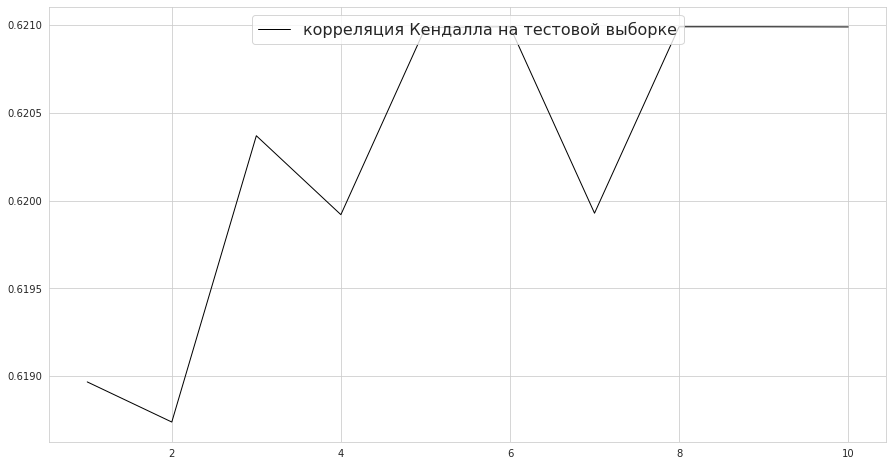

In [11]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(range(1, n_epoch + 1), test_kend_collection, linewidth=1, label="корреляция Кендалла на тестовой выборке", color="black")

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

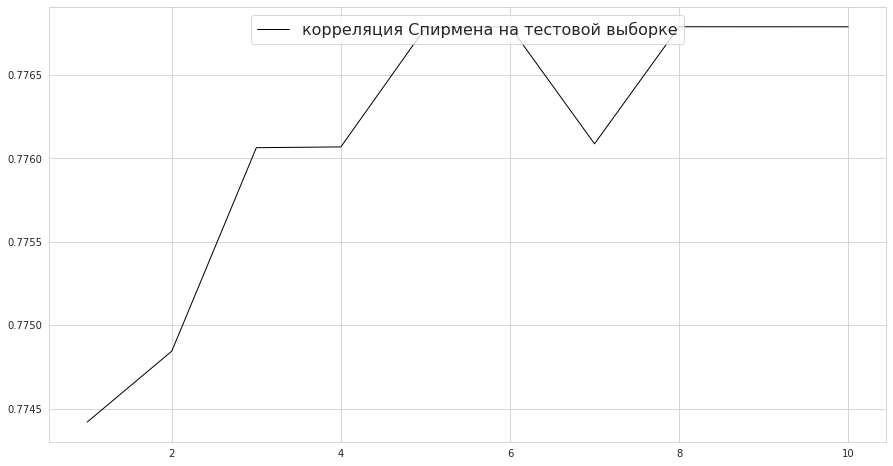

In [12]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(range(1, n_epoch + 1), test_spear_collection, linewidth=1, label="корреляция Спирмена на тестовой выборке", color="black")

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

Из графиков видно, что корреляции потихоньку растут

# 5 Рейтинг вопросов

In [13]:
player_len = df_train.nunique()['player_id']
questions_features_names = pipe['one_hot'].get_feature_names()[player_len: ]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
question_ids = [name.split('_')[-2] + " " + name.split('_')[-1] for name in questions_features_names]
question_weights = pipe['linreg'].coef_[player_len: ]
map_id_to_weight = dict(zip(question_ids, question_weights))

In [39]:
map_tour_weight = defaultdict(lambda: 0)
for key, weight in map_id_to_weight.items():
  tour_id, _ = map(int, key.split())
  map_tour_weight[tour_id] += weight
map_tour_weight = dict(sorted(map_tour_weight.items(), key=lambda item: item[1], reverse=True))
list_sorted_tour = list(zip(map_tour_weight.keys(), map_tour_weight.values()))
top_10_hard_tour = list_sorted_tour[: 10]
top_10_easy_tour = list_sorted_tour[-10: ]


In [40]:
top_10_easy_tour

[(5903, -6.943784324224534),
 (5368, -7.164220374323566),
 (5451, -7.349525570368073),
 (5795, -8.129471510037629),
 (5928, -9.530103529699991),
 (5864, -10.590838768388776),
 (6085, -11.62963887614168),
 (5465, -13.963386443311837),
 (6150, -22.121521312859258),
 (6149, -54.35582188906111)]

In [35]:
top_10_hard_tour

[(6254, 44.09549255890255),
 (6249, 42.95091299868013),
 (5827, 26.258403822982586),
 (5592, 13.557401995737457),
 (6008, 12.409159914963393),
 (5660, 11.500601209244664),
 (5791, 8.80760045212226),
 (5457, 8.725246850853411),
 (5488, 8.666375996299026),
 (5635, 8.47035530486486)]

## 10 Сложных турниров

In [47]:
tour_string = ""
for tour_id, _ in top_10_hard_tour:
  tour_string += (tournaments_df[tournaments_df.id == tour_id].name.values[0] + "\n")
print(tour_string)

Школьная лига
Школьный синхрон-lite. Сезон 3
Шестой киевский марафон. Асинхрон
Студенческая лига ЧТ
Малый кубок Физтеха
Первая лига ЧТ
Кубок княгини Ольги среди школьников
Студенческий чемпионат Калининградской области
Чемпионат Беларуси среди школьников
Открытый кубок Дальнего Востока (школьный зачёт)



## 10 Простых турниров

In [48]:
tour_string = ""
for tour_id, _ in top_10_easy_tour:
  tour_string += (tournaments_df[tournaments_df.id == tour_id].name.values[0] + "\n")
print(tour_string)

Беловежская Зима
AU
Весна в ЛЭТИ
Кубок Москвы
Угрюмый Ёрш
Гран-при Славянки. Общий зачет
Серия Гран-при. Общий зачёт
Чемпионат России
Чемпионат Санкт-Петербурга. Высшая лига
Чемпионат Санкт-Петербурга. Первая лига



Я думаю так получилось, потому что, модель не учитывает, что на турниры для школьников приходят более слабые игроки, у которых меньше вероятность дать правильный ответ, в следствии чего получается на турнире отвечают на меньшее количество вопросов.